<a href="https://colab.research.google.com/github/disha2sinha/Movie-Recommendation-System/blob/master/Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTING LIBRARIES:**

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
!pip install rake_nltk
from rake_nltk import Rake 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#https://drive.google.com/file/d/1HcaON_5Qz-bfqlRyDgVWfdS4bD0hQ0Z3/view?usp=sharing

In [3]:
id='1HcaON_5Qz-bfqlRyDgVWfdS4bD0hQ0Z3'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('MoviesData.csv')  
movies_data = pd.read_csv('MoviesData.csv',engine='python',index_col=0)
movies_data.head()

,title,release_year,release_day,genres,original_language,runtime,content,production_companies,budget,revenue,profit,production_countries,status,popularity,vote_average,vote_count,movieId,cast,director,rating_count,mean_rating
0,Se7en,1995,Friday,Crime|Mystery|Thriller,English,127.0,Two homicide detectives are on a desperate hun...,New Line Cinema|Juno Pix|Cecchi Gori Pictures,33000000,327311859.0,294311859.0,United States of America,Released,18.457430,8.1,5915.0,47,Brad Pitt|Morgan Freeman|Gwyneth Paltrow|John ...,David Fincher,91921.0,4.052926
1,Batman,1989,Friday,Fantasy|Action,English,126.0,The Dark Knight of Gotham City begins his war ...,PolyGram Filmed Entertainment|The Guber-Peters...,35000000,411348924.0,376348924.0,United Kingdom|United States of America,Released,19.106730,7.0,2145.0,592,Jack Nicholson|Michael Keaton|Kim Basinger|Mic...,Tim Burton,91082.0,4.429015
2,The Empire Strikes Back,1980,Saturday,Adventure|Action|Science Fiction,English,124.0,"The epic saga continues as Luke Skywalker, in ...",Lucasfilm|Twentieth Century Fox Film Corporation,18000000,538400000.0,520400000.0,United States of America,Released,19.470959,8.2,5998.0,1196,Mark Hamill|Harrison Ford|Carrie Fisher|Billy ...,Irvin Kershner,87901.0,4.169975
3,Drag Me to Hell,2009,Sunday,Horror|Thriller,English,99.0,After denying a woman the extension she needs ...,Universal Pictures|Ghost House Pictures|Mandat...,30000000,90810892.0,60810892.0,United States of America,Released,15.809588,6.2,995.0,68952,Alison Lohman|Justin Long|Lorna Raver|Dileep R...,Sam Raimi,84078.0,4.152246
4,Suspect,1987,Friday,Crime|Drama|Thriller,English,121.0,When a Supreme Court judge commits suicide and...,TriStar Pictures,8000000,18782400.0,10782400.0,United States of America,Released,10.638289,6.4,45.0,4332,Cher|Dennis Quaid|Liam Neeson|John Mahoney|Joe...,Peter Yates,77960.0,4.154098


# **POPULARITY BASED RECOMMENDATION SYSTEM :**

In [4]:
movies_data[['vote_count','vote_average','rating_count','mean_rating','popularity']].describe()

,vote_count,vote_average,rating_count,mean_rating,popularity
count,45663.000000,45663.000000,45663.000000,45663.000000,45663.000000
mean,109.588179,5.617947,484.200666,0.771628,2.922354
std,490.228641,1.924399,2943.748802,1.389116,5.996711
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,5.000000,0.000000,0.000000,0.386454
50%,10.000000,6.000000,0.000000,0.000000,1.129126
75%,34.000000,6.800000,0.000000,0.000000,3.685682
max,14075.000000,10.000000,91921.000000,5.000000,547.488298


**WEIGHTED AVERAGE FOR EACH MOVIES AVERAGE RATINGS :**

Weighted Ratings: 
>              W =   Rv + Cm
>                   ---------
                     v+m

R= average rating for the movie as a number from 0 to 10

v= number of votes for the movie

m= minimum votes required to be listed in Top(here 2000)

C=the mean vote across whole report


In [5]:
R=movies_data['vote_average']
v=movies_data['vote_count']
C=movies_data['vote_average'].mean()
m=2000

In [6]:
movies_data['weighted_votes']=(R*v+C*m)/(v+m)
movies_data[['title','weighted_votes']].sort_values('weighted_votes',ascending=False).head(20)

,title,weighted_votes
67,The Shawshank Redemption,7.943512
1555,The Dark Knight,7.924073
2120,Fight Club,7.840666
2130,Pulp Fiction,7.797272
6075,Inception,7.791191
9040,The Godfather,7.781642
33564,Interstellar,7.723561
109,Forrest Gump,7.691071
2594,The Lord of the Rings: The Return of the King,7.614560
1942,The Lord of the Rings: The Fellowship of the Ring,7.562605


In [7]:
R1=movies_data['mean_rating']
v1=movies_data['rating_count']
C1=movies_data['mean_rating'].mean()
m1=movies_data['rating_count'].quantile(0.95)
m1

1643.9000000000015

In [8]:
movies_data['weighted_ratings']=(R1*v1+C1*m1)/(v1+m1)
movies_data[['title','weighted_ratings']].sort_values('weighted_ratings',ascending=False).head(20)

,title,weighted_ratings
1,Batman,4.364174
19,Three Days of the Condor,4.239907
15,Maze Runner: The Scorch Trials,4.204964
7,Dracula Untold,4.183633
13,Far from Heaven,4.138506
63,The Truman Show,4.113689
2,The Empire Strikes Back,4.107587
47,Street Kings,4.092986
3,Drag Me to Hell,4.087415
4,Suspect,4.084247


**ASSIGNING SCORES TO THE MOVIES BY GIVING 45% IMPORTANCE TO WEIGHTED AVERAGE OF VOTES + 45% IMPORTANCE TO POPULARITY + 10% TO WEIGHTED AVERAGE OF RATINGS**

In [9]:
scaler=MinMaxScaler()
movies_data[['weighted_votes','weighted_ratings','popularity']]=scaler.fit_transform(movies_data[['weighted_votes','weighted_ratings','popularity']])
movies_data['score']=movies_data['weighted_votes']*0.45 + movies_data['weighted_ratings']*0.1+movies_data['popularity']*0.45
movies_data[['title','weighted_votes','weighted_ratings','popularity','score']].sort_values('score',ascending=False).head(10)

,title,weighted_votes,weighted_ratings,popularity,score
27517,Minions,0.404024,0.000274,1.000000,0.631838
9,Wonder Woman,0.599344,0.846461,0.537613,0.596277
1555,The Dark Knight,0.993477,0.356847,0.224968,0.583985
2130,Pulp Fiction,0.950925,0.375564,0.257449,0.581325
67,The Shawshank Redemption,1.000000,0.757741,0.094332,0.568223
1609,Big Hero 6,0.775159,0.377674,0.390602,0.562360
116,Guardians of the Galaxy Vol. 2,0.690749,0.807078,0.338511,0.543875
328,Deadpool,0.728643,0.580056,0.343132,0.540304
131,Beauty and the Beast,0.510901,0.645611,0.524675,0.530570
1218,Gone Girl,0.794494,0.454052,0.282748,0.530164


**ONLY MOVIES HAVING SCORE ABOVE A THRESHOLD VALUE CONSIDERED POPULAR :**

In [10]:
movies_data.score.describe()

count    45663.000000
mean         0.110041
std          0.030936
min          0.030931
25%          0.099160
50%          0.100148
75%          0.104319
max          0.631838
Name: score, dtype: float64

In [11]:
movies_data[movies_data['score']>=0.0992].movieId.count()

33593

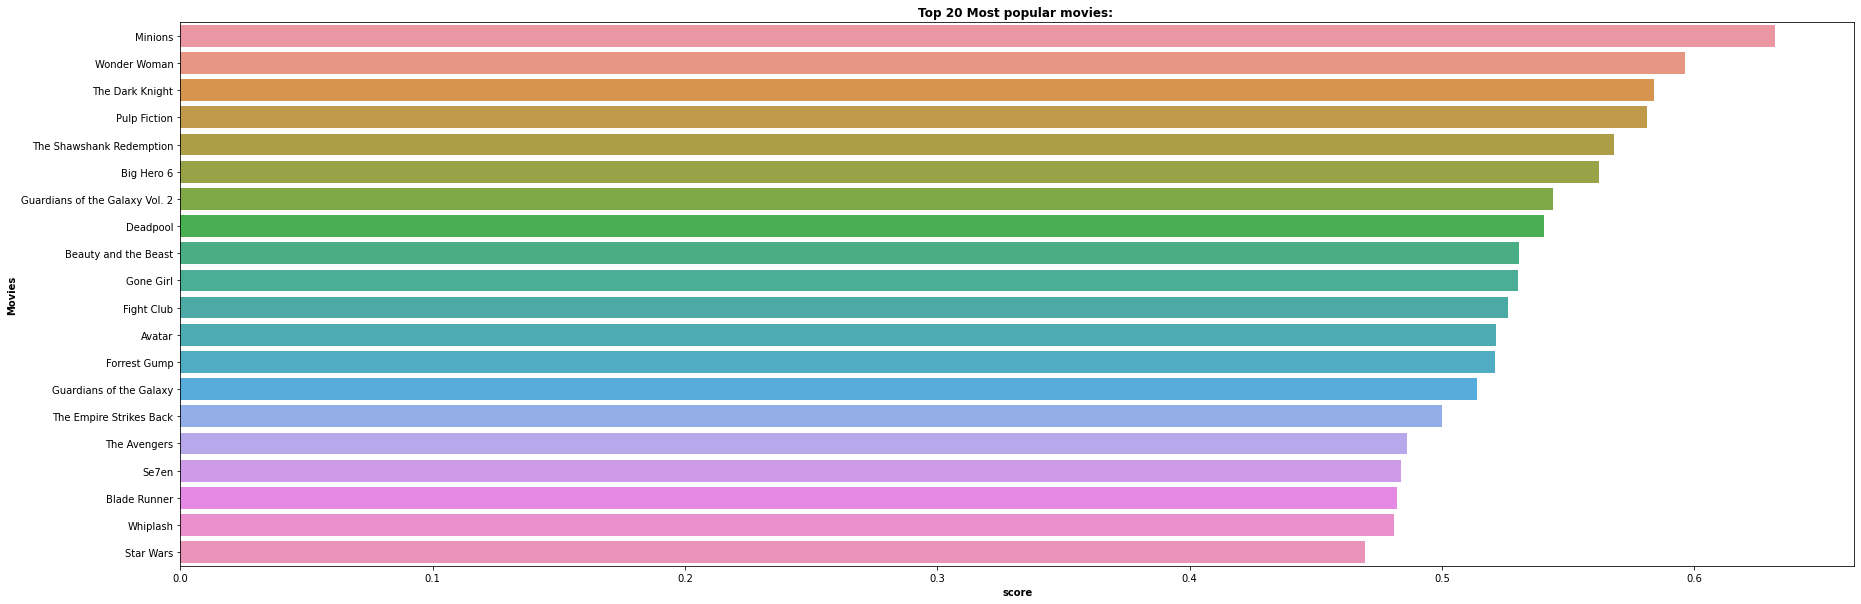

In [12]:
popular_movies=movies_data[movies_data['score']>=0.0992]
popular_movies=popular_movies[['movieId','title','budget','profit','score','release_year','release_day','genres','production_countries','production_companies','original_language','runtime','content','status','cast','director']].sort_values('score',ascending=False).reset_index(drop=True)
plt.figure(figsize=(30,10))
axis=sns.barplot(x=popular_movies['score'].head(20),y=popular_movies['title'].head(20))
plt.title('Top 20 Most popular movies: ',weight='bold')
plt.xlabel('score',weight='bold')
plt.ylabel('Movies',weight='bold')
plt.savefig('PopularMovies.jpg')

In [13]:
popular_movies.shape

(33593, 16)

In [14]:
popular_movies.head()

,movieId,title,budget,profit,score,release_year,release_day,genres,production_countries,production_companies,original_language,runtime,content,status,cast,director
0,135887,Minions,74000000,1.082731e+09,0.631838,2015,Wednesday,Family|Animation|Adventure|Comedy,United States of America,Universal Pictures|Illumination Entertainment,English,91.0,"Minions Stuart, Kevin and Bob are recruited by...",Released,Sandra Bullock|Jon Hamm|Michael Keaton|Allison...,Kyle Balda
1,143355,Wonder Woman,149000000,6.715804e+08,0.596277,2017,Tuesday,Action|Adventure|Fantasy,United States of America,Dune Entertainment|Atlas Entertainment|Warner ...,English,141.0,An Amazon princess comes to the world of Man t...,Released,Gal Gadot|Chris Pine|Robin Wright|Danny Huston...,Patty Jenkins
2,58559,The Dark Knight,185000000,8.195584e+08,0.583985,2008,Wednesday,Drama|Action|Crime|Thriller,United Kingdom|United States of America,DC Comics|Legendary Pictures|Warner Bros.|DC E...,English,152.0,Batman raises the stakes in his war on crime. ...,Released,Christian Bale|Michael Caine|Heath Ledger|Aaro...,Christopher Nolan
3,296,Pulp Fiction,8000000,2.059288e+08,0.581325,1994,Saturday,Thriller|Crime,United States of America,Miramax Films|A Band Apart|Jersey Films,English,154.0,"A burger-loving hit man, his philosophical par...",Released,John Travolta|Samuel L. Jackson|Uma Thurman|Br...,Quentin Tarantino
4,318,The Shawshank Redemption,25000000,3.341469e+06,0.568223,1994,Friday,Drama|Crime,United States of America,Castle Rock Entertainment|Warner Bros.,English,142.0,Framed in the 1940s for the double murder of h...,Released,Tim Robbins|Morgan Freeman|Bob Gunton|Clancy B...,Frank Darabont


# **CONTENT - BASED RECOMMENDATION SYSTEM ON POPULAR MOVIES**

**KEY WORDS FOR EACH MOVIE :**

In [15]:
movies_data.head()

,title,release_year,release_day,genres,original_language,runtime,content,production_companies,budget,revenue,profit,production_countries,status,popularity,vote_average,vote_count,movieId,cast,director,rating_count,mean_rating,weighted_votes,weighted_ratings,score
0,Se7en,1995,Friday,Crime|Mystery|Thriller,English,127.0,Two homicide detectives are on a desperate hun...,New Line Cinema|Juno Pix|Cecchi Gori Pictures,33000000,327311859.0,294311859.0,United States of America,Released,0.033713,8.1,5915.0,47,Brad Pitt|Morgan Freeman|Gwyneth Paltrow|John ...,David Fincher,91921.0,4.052926,0.842046,0.897343,0.483826
1,Batman,1989,Friday,Fantasy|Action,English,126.0,The Dark Knight of Gotham City begins his war ...,PolyGram Filmed Entertainment|The Guber-Peters...,35000000,411348924.0,376348924.0,United Kingdom|United States of America,Released,0.034899,7.0,2145.0,592,Jack Nicholson|Michael Keaton|Kim Basinger|Mic...,Tim Burton,91082.0,4.429015,0.459592,1.000000,0.322521
2,The Empire Strikes Back,1980,Saturday,Adventure|Action|Science Fiction,English,124.0,"The epic saga continues as Luke Skywalker, in ...",Lucasfilm|Twentieth Century Fox Film Corporation,18000000,538400000.0,520400000.0,United States of America,Released,0.035564,8.2,5998.0,1196,Mark Hamill|Harrison Ford|Carrie Fisher|Billy ...,Irvin Kershner,87901.0,4.169975,0.869397,0.928598,0.500092
3,Drag Me to Hell,2009,Sunday,Horror|Thriller,English,99.0,After denying a woman the extension she needs ...,Universal Pictures|Ghost House Pictures|Mandat...,30000000,90810892.0,60810892.0,United States of America,Released,0.028877,6.2,995.0,68952,Alison Lohman|Justin Long|Lorna Raver|Dileep R...,Sam Raimi,84078.0,4.152246,0.284476,0.922984,0.233307
4,Suspect,1987,Friday,Crime|Drama|Thriller,English,121.0,When a Supreme Court judge commits suicide and...,TriStar Pictures,8000000,18782400.0,10782400.0,United States of America,Released,0.019431,6.4,45.0,4332,Cher|Dennis Quaid|Liam Neeson|John Mahoney|Joe...,Peter Yates,77960.0,4.154098,0.225360,0.922102,0.202366


In [16]:
movies_data['keywords']=movies_data['cast'].apply(str)+" "+movies_data['production_companies'].apply(str)+" "+movies_data['production_countries'].apply(str)+" "+movies_data['content'].apply(str)+" "+movies_data['genres'].apply(str)+" "+movies_data['director'].apply(str)+" "+movies_data['release_day'].apply(str)+" "+movies_data['budget'].apply(str)+" "+movies_data['profit'].apply(str)+" "+movies_data['runtime'].apply(str)+" "+movies_data['status'].apply(str)+" "+movies_data['original_language'].apply(str)
movies_data['important_words']=""
for index,row in movies_data.iterrows():
  keywords=row['keywords']
  r=Rake()
  r.extract_keywords_from_text(keywords)
  keywords_scores=r.get_word_degrees()
  movies_data.at[index,'important_words']=list(keywords_scores.keys())


In [17]:
movies_data['important_words']=[','.join(map(str,word)) for word in movies_data['important_words']]
movies_data.drop('keywords',inplace=True,axis=1)
movies_data.head()

,title,release_year,release_day,genres,original_language,runtime,content,production_companies,budget,revenue,profit,production_countries,status,popularity,vote_average,vote_count,movieId,cast,director,rating_count,mean_rating,weighted_votes,weighted_ratings,score,important_words
0,Se7en,1995,Friday,Crime|Mystery|Thriller,English,127.0,Two homicide detectives are on a desperate hun...,New Line Cinema|Juno Pix|Cecchi Gori Pictures,33000000,327311859.0,294311859.0,United States of America,Released,0.033713,8.1,5915.0,47,Brad Pitt|Morgan Freeman|Gwyneth Paltrow|John ...,David Fincher,91921.0,4.052926,0.842046,0.897343,0.483826,"based,juno,pix,leland,orser,r,mario,di,donato,..."
1,Batman,1989,Friday,Fantasy|Action,English,126.0,The Dark Knight of Gotham City begins his war ...,PolyGram Filmed Entertainment|The Guber-Peters...,35000000,411348924.0,376348924.0,United Kingdom|United States of America,Released,0.034899,7.0,2145.0,592,Jack Nicholson|Michael Keaton|Kim Basinger|Mic...,Tim Burton,91082.0,4.429015,0.459592,1.000000,0.322521,"0,126,warner,bros,jack,palance,underworld,dark..."
2,The Empire Strikes Back,1980,Saturday,Adventure|Action|Science Fiction,English,124.0,"The epic saga continues as Luke Skywalker, in ...",Lucasfilm|Twentieth Century Fox Film Corporation,18000000,538400000.0,520400000.0,United States of America,Released,0.035564,8.2,5998.0,1196,Mark Hamill|Harrison Ford|Carrie Fisher|Billy ...,Irvin Kershner,87901.0,4.169975,0.869397,0.928598,0.500092,"evil,galactic,empire,michael,santiago,twentiet..."
3,Drag Me to Hell,2009,Sunday,Horror|Thriller,English,99.0,After denying a woman the extension she needs ...,Universal Pictures|Ghost House Pictures|Mandat...,30000000,90810892.0,60810892.0,United States of America,Released,0.028877,6.2,995.0,68952,Alison Lohman|Justin Long|Lorna Raver|Dileep R...,Sam Raimi,84078.0,4.152246,0.284476,0.922984,0.233307,"ricardo,molina,octavia,spencer,ruth,livier,nee..."
4,Suspect,1987,Friday,Crime|Drama|Thriller,English,121.0,When a Supreme Court judge commits suicide and...,TriStar Pictures,8000000,18782400.0,10782400.0,United States of America,Released,0.019431,6.4,45.0,4332,Cher|Dennis Quaid|Liam Neeson|John Mahoney|Joe...,Peter Yates,77960.0,4.154098,0.225360,0.922102,0.202366,"lisbeth,bartlett,tristar,pictures,united,state..."


In [18]:
movies_data['release_year'].min()

'1874'

### **DIVIDING DATASET INTO SMALLER DATASETS ACCORDING TO THEIR YEAR OF RELEASE**

## **MOVIES RELEASED BETWEEN YEAR 2010 AND YEAR 2020**

In [19]:
movies2010_2020=movies_data[(movies_data['release_year']>='2010')&(movies_data['release_year']<='2020')]
movies2010_2020.drop('release_year',inplace=True,axis=1)
movies2010_2020=movies2010_2020.reset_index(drop=True)
indices2010_2020=pd.Series(movies2010_2020.index, index=movies2010_2020['title']).drop_duplicates()
print("There are {} movies in the dataset that released between 2010-2020".format(movies2010_2020.shape[0]))
movies2010_2020.head()

There are 12839 movies in the dataset that released between 2010-2020


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,title,release_day,genres,original_language,runtime,content,production_companies,budget,revenue,profit,production_countries,status,popularity,vote_average,vote_count,movieId,cast,director,rating_count,mean_rating,weighted_votes,weighted_ratings,score,important_words
0,The A-Team,Thursday,Thriller|Action|Adventure|Comedy|Crime,English,117.0,A group of Iraq War veterans goes on the run f...,Ingenious Film Partners|Twentieth Century Fox ...,110000000,177238796.0,67238796.0,United States of America,Released,0.030590,6.2,1737.0,78469,Liam Neeson|Bradley Cooper|Jessica Biel|Sharlt...,Joe Carnahan,74355.0,3.660238,0.310375,0.786723,0.232107,"along,brian,bloom,clear,hannibal,smith,stefan,..."
1,Dracula Untold,Wednesday,Horror|Action|Drama|Fantasy|War,English,92.0,"Vlad Tepes is a great hero, but when he learns...",Universal Pictures|Legendary Pictures|Fuji Tel...,70000000,215529201.0,145529201.0,United States of America,Released,0.029802,6.2,2439.0,114795,Luke Evans|Sarah Gadon|Dominic Cooper|Art Park...,Gary Shore,67662.0,4.266531,0.326907,0.949760,0.255495,"000,boys,ronan,vibert,find,form,action,paul,ka..."
2,Wonder Woman,Tuesday,Action|Adventure|Fantasy,English,141.0,An Amazon princess comes to the world of Man t...,Dune Entertainment|Atlas Entertainment|Warner ...,149000000,820580447.0,671580447.0,United States of America,Released,0.537613,7.2,5025.0,143355,Gal Gadot|Chris Pine|Robin Wright|Danny Huston...,Patty Jenkins,66008.0,3.888157,0.599344,0.846461,0.596277,"david,thewlis,ben,kelleher,jemma,moore,ann,ogb..."
3,Deepwater Horizon,Thursday,Drama|Action,English,107.0,A story set on the offshore drilling rig Deepw...,Di Bonaventura Pictures|Summit Entertainment|P...,110000000,121790373.0,11790373.0,Hong Kong|United States of America,Released,0.024107,6.5,1478.0,162598,Mark Wahlberg|Kurt Russell|John Malkovich|Gina...,Peter Berg,62714.0,3.989612,0.345372,0.872894,0.253555,"leverage,entertainment,j,summit,henry,frost,fa..."
4,Descendants 2,Friday,TV Movie|Family|Action|Comedy|Music|Adventure,English,111.0,When the pressure to be royal becomes too much...,Walt Disney Television,8000000,16822718.5,8822718.5,United States of America,Released,0.028936,7.5,171.0,175795,Dove Cameron|Sofia Carson|Cameron Boyce|Booboo...,Kenny Ortega,61836.0,3.939000,0.269332,0.858858,0.220106,"archenemy,uma,dove,cameron,action,kristin,chen..."


In [20]:
tf=TfidfVectorizer(min_df=3,max_features=None,strip_accents='unicode',ngram_range=(1,3),stop_words='english')
tvf_matrix2010_2020=tf.fit_transform(movies2010_2020['important_words'])

In [21]:
tvf_matrix2010_2020.shape

(12839, 69214)

In [ ]:
tvf_matrix2010_2020df=pd.DataFrame(tvf_matrix2010_2020.todense(),index=movies2010_2020.title)
tvf_matrix2010_2020df.head()

In [22]:
#cosine_sim2010_2020=cosine_similarity(tvf_matrix2010_2020,tvf_matrix2010_2020)

## **PAIRWISE SIMILARITY FOR THE MOVIES RELEASED BETWEEN 2010 AND 2020**

In [23]:
#cosine_sim2010_2020df=pd.DataFrame(cosine_sim2010_2020,index=movies2010_2020.title,columns=movies2010_2020.title)
#cosine_sim2010_2020df.head()

title,The A-Team,Dracula Untold,Wonder Woman,Deepwater Horizon,Descendants 2,Maze Runner: The Scorch Trials,Mortdecai,The Martian,Smurfs: The Lost Village,Guardians of the Galaxy,Ted 2,Electrick Children,The Gunman,Taken 3,Gantz:O,Rings,Who Am I,The Hunger Games: Catching Fire,A Walk Among the Tombstones,The Shrine,Shot Caller,Jason Bourne,Wrong Turn 5: Bloodlines,Crimson Peak,The Bélier Family,Super 8,The Chronicles of Narnia: The Voyage of the Dawn Treader,Gravity,Ca$h,A Man Called Ove,Getaway,Inherent Vice,The Hunger Games: Mockingjay - Part 1,Barely Lethal,Into the Grizzly Maze,Precious Cargo,Hotel Transylvania,The Kid with a Bike,It Follows,Cut Bank,...,My Lucky Star,Bolshoi Babylon,A Violent Prosecutor,Kitchen in Paris,DC Super Hero Girls: Hero of the Year,Klitschko,Coda,Ajin: Demi-Human - Compel,Me Too,Closer to the Moon,Pernicious,Bombay Velvet,Les Invités de mon père,Fire of Conscience,Cherry Tree,The 24 Hour War,The Pruitt-Igoe Myth,Yelling To The Sky,The Untold History of the United States,All About E,Wild Oats,The Spirit of Christmas,Hannibal Buress: Animal Furnace,Page One: Inside the New York Times,MindGamers,Love Birds,The Similars,Dügün Dernek 2: Sünnet,The Last Match,A Lesson in Romance,Double Dhamaal,Time Traveller: The Girl Who Leapt Through Time,The Emperor in August,My Joy,Dig Two Graves,Aftermath,Glen Campbell: I'll Be Me,"3 ½ Minutes, 10 Bullets",Hate Story 2,Ethel & Ernest
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
The A-Team,1.000000,0.025340,0.028902,0.029343,0.033989,0.026291,0.021793,0.058771,0.017309,0.031552,0.047815,0.018220,0.008944,0.070192,0.004357,0.015672,0.008575,0.023408,0.042103,0.014597,0.040437,0.044644,0.027376,0.011890,0.004115,0.017250,0.064607,0.006186,0.020664,0.009557,0.012111,0.049998,0.032937,0.028961,0.019881,0.016673,0.020348,0.000133,0.013736,0.016621,...,0.009231,0.003440,0.018687,0.005326,0.015041,0.007035,0.006227,0.003209,0.014043,0.015296,0.008990,0.012998,0.005187,0.005543,0.012980,0.014238,0.005383,0.020093,0.009195,0.021902,0.014168,0.008044,0.018208,0.022670,0.017035,0.009807,0.006410,0.000424,0.007107,0.013831,0.013792,0.002349,0.006265,0.020078,0.020749,0.005806,0.023645,0.022606,0.006377,0.006803
Dracula Untold,0.025340,1.000000,0.014467,0.007961,0.013852,0.021010,0.020046,0.013712,0.006549,0.018706,0.023680,0.006037,0.007609,0.005787,0.004268,0.019904,0.007870,0.008201,0.008538,0.006680,0.010693,0.019085,0.015094,0.030581,0.011078,0.018792,0.018823,0.010991,0.012458,0.005733,0.013544,0.015782,0.010791,0.013743,0.016527,0.008644,0.025482,0.006662,0.021814,0.017502,...,0.000201,0.001708,0.002532,0.000248,0.016650,0.008837,0.010122,0.010876,0.006064,0.006879,0.006161,0.002762,0.004024,0.014530,0.033913,0.016493,0.006509,0.009410,0.011120,0.015659,0.009455,0.010847,0.006383,0.018312,0.027185,0.016564,0.003152,0.000513,0.007926,0.020087,0.003000,0.000210,0.003782,0.024697,0.009795,0.003808,0.012023,0.011023,0.001014,0.012598
Wonder Woman,0.028902,0.014467,1.000000,0.018888,0.015718,0.024166,0.011230,0.025999,0.012391,0.026725,0.020590,0.013757,0.015357,0.027228,0.002945,0.024202,0.005382,0.016198,0.016194,0.020284,0.019521,0.075710,0.016779,0.019421,0.011745,0.010579,0.041279,0.017986,0.008297,0.002768,0.006581,0.041570,0.020930,0.042211,0.014478,0.005088,0.029718,0.001741,0.011426,0.008111,...,0.001709,0.005912,0.002810,0.005820,0.036705,0.007577,0.001245,0.006228,0.003876,0.017502,0.023048,0.001857,0.000169,0.002561,0.010616,0.008317,0.001683,0.026742,0.005803,0.007454,0.015383,0.007888,0.010591,0.027808,0.019293,0.007508,0.009076,0.000379,0.000747,0.018862,0.013012,0.002099,0.002589,0.004299,0.026543,0.000235,0.013570,0.029505,0.004951,0.005629
Deepwater Horizon,0.029343,0.007961,0.018888,1.000000,0.015780,0.025857,0.014840,0.020116,0.020659,0.024634,0.031164,0.018841,0.012192,0.025850,0.002306,0.011691,0.014087,0.010127,0.014502,0.010528,0.030054,0.023259,0.023710,0.011058,0.004366,0.008041,0.015065,0.004155,0.015581,0.0

## **MOVIES RELEASED BETWEEN YEAR 2000 AND YEAR 2010**

In [24]:
movies2000_2010=movies_data[(movies_data['release_year']>='2000')&(movies_data['release_year']<'2010')]
movies2000_2010.drop('release_year',inplace=True,axis=1)
movies2000_2010=movies2000_2010.reset_index(drop=True)
indices2000_2010=pd.Series(movies2000_2010.index, index=movies2000_2010['title']).drop_duplicates()
print("There are {} movies in the dataset that released between 2010-2020".format(movies2000_2010.shape[0]))
movies2000_2010.head()

There are 11296 movies in the dataset that released between 2010-2020


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,title,release_day,genres,original_language,runtime,content,production_companies,budget,revenue,profit,production_countries,status,popularity,vote_average,vote_count,movieId,cast,director,rating_count,mean_rating,weighted_votes,weighted_ratings,score,important_words
0,Drag Me to Hell,Sunday,Horror|Thriller,English,99.0,After denying a woman the extension she needs ...,Universal Pictures|Ghost House Pictures|Mandat...,30000000,90810892.0,60810892.0,United States of America,Released,0.028877,6.2,995.0,68952,Alison Lohman|Justin Long|Lorna Raver|Dileep R...,Sam Raimi,84078.0,4.152246,0.284476,0.922984,0.233307,"ricardo,molina,octavia,spencer,ruth,livier,nee..."
1,V for Vendetta,Wednesday,Action|Thriller|Fantasy,English,132.0,In a world in which Great Britain has become a...,Studio Babelsberg|DC Comics|Virtual Studios|An...,54000000,132511035.0,78511035.0,Germany|United Kingdom|United States of America,Released,0.036922,7.7,4562.0,44191,Natalie Portman|Hugo Weaving|Stephen Rea|Steph...,James McTeigue,77045.0,4.132299,0.705330,0.915937,0.425607,"brandenburg,roger,allam,chad,stahelski,dickins..."
2,The Twilight Saga: New Moon,Sunday,Adventure|Fantasy|Drama|Romance,English,130.0,"Forks, Washington resident Bella Swan is reeli...",Summit Entertainment|Maverick Films|Imprint En...,50000000,709827462.0,659827462.0,United States of America,Released,0.055017,5.6,2518.0,72407,Kristen Stewart|Robert Pattinson|Taylor Lautne...,Chris Weitz,66512.0,4.016057,0.216229,0.881350,0.210196,"jacob,black,sunswept,entertainment,justin,chon..."
3,Far from Heaven,Sunday,Drama|Romance,English,107.0,"In 1950s Connecticut, a housewife faces a mari...",Clear Blue Sky Productions,13500000,29027914.0,15527914.0,United States of America,Released,0.018462,6.9,145.0,5812,Julianne Moore|Dennis Quaid|Dennis Haysbert|Pa...,Todd Haynes,60024.0,4.230716,0.248668,0.937202,0.213929,"romance,todd,haynes,sunday,13500000,15527914,c..."
4,The Sea Inside,Friday,Drama,Español,125.0,The Sea Inside is about Spaniard Ramón Sampedr...,Canal Plus|Sogecine|Himenóptero|Eurimages|Tele...,12806000,38535221.0,25729221.0,Spain|France|Italy,Released,0.026846,7.2,224.0,27803,Javier Bardem|Belén Rueda|Lola Dueñas|Joan Dal...,Alejandro Amenábar,57232.0,3.397042,0.273058,0.710469,0.206003,"francesc,garrido,julio,jordán,televisión,españ..."


In [25]:
tvf_matrix2000_2010=tf.fit_transform(movies2000_2010['important_words'])
tvf_matrix2000_2010.shape

(11296, 60580)

In [26]:
#cosine_sim2000_2010=cosine_similarity(tvf_matrix2000_2010,tvf_matrix2000_2010)
#cosine_sim2000_2010df=pd.DataFrame(cosine_sim2000_2010,index=movies2000_2010.title,columns=movies2000_2010.title)
#cosine_sim2000_2010df.head()

title,Drag Me to Hell,V for Vendetta,The Twilight Saga: New Moon,Far from Heaven,The Sea Inside,Black Water,Nick and Norah's Infinite Playlist,Lara Croft: Tomb Raider,College,Carrie,Donnie Darko,The Pink Panther 2,Troy,Step Brothers,The Big White,The Cell,The Amityville Horror,Street Kings,I Am Sam,The Interpreter,Intolerable Cruelty,American Psycho,The Punisher,The Matrix Reloaded,Gangs of New York,The Pursuit of Happyness,Salton Sea,The Black Dahlia,The Edge of Love,The Fall,Harry Potter and the Chamber of Secrets,Exorcist: The Beginning,Meet the Parents,Cars,The Baader Meinhof Complex,Eastern Promises,Serving Sara,Burn After Reading,Holes,Harry Potter and the Goblet of Fire,...,"Musée haut, musée bas",Balibo,The Jammed,Krazzy 4,The Wild and Wonderful Whites of West Virginia,Albino Farm,A Woman in Berlin,North,The Yes Men Fix the World,The Hexer,Ten Canoes,Midnight Movies: From the Margin to the Mainstream,How to Make a Monster,Phir Hera Pheri,A Christmas Carol,Mujhse Dosti Karoge!,Just Ask My Children,Fast Track: No Limits,Lovers of the Café Flore,Autumn Ball,An American Girl: Chrissa Stands Strong,Slingshot,Tom Thumb,Suburban Mayhem,Fist of the North Star: Legend of Toki,Red Doors,There's Only One Sun,Opposite Day,Father of My Children,Street Fight,My Boy Jack,Devil's Diary,Against the Ropes,The Perfect Holiday,No Entry,Shoot on Sight,The Garden of Sinners - Chapter 4: The Hollow Shrine,Legacy,The Most Beautiful Night In The World,16 Years of Alcohol
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Drag Me to Hell,1.000000,0.032567,0.031683,0.023617,0.006408,0.007926,0.054723,0.029868,0.016257,0.017984,0.029246,0.026549,0.021270,0.020256,0.049877,0.024504,0.024736,0.026100,0.017275,0.022100,0.033156,0.023717,0.030698,0.028575,0.021250,0.028985,0.012112,0.029955,0.010314,0.009724,0.019206,0.025569,0.027122,0.017871,0.007693,0.012446,0.006848,0.016890,0.024451,0.025750,...,0.004238,0.008002,0.021377,0.000185,0.009501,0.017775,0.008357,0.008306,0.044594,0.001450,0.007250,0.021715,0.008434,0.011111,0.009056,0.004207,0.031197,0.003854,0.002969,0.007569,0.052030,0.013335,0.000213,0.030968,0.000286,0.032559,0.001982,0.003383,0.022908,0.006118,0.019014,0.016426,0.008691,0.019437,0.009990,0.029621,0.000245,0.009875,0.005274,0.005705
V for Vendetta,0.032567,1.000000,0.015246,0.014052,0.005568,0.026204,0.017583,0.029380,0.014404,0.024633,0.022671,0.023208,0.039519,0.020668,0.023750,0.019359,0.017125,0.012332,0.027727,0.025196,0.019348,0.025711,0.045606,0.050566,0.058588,0.025424,0.015505,0.019357,0.025129,0.022978,0.051557,0.019571,0.021272,0.021372,0.030063,0.060310,0.018116,0.032849,0.019125,0.046631,...,0.004435,0.010653,0.012527,0.003151,0.017736,0.011218,0.011992,0.002762,0.028917,0.006624,0.007459,0.013123,0.016866,0.000794,0.006589,0.000150,0.017822,0.016532,0.007649,0.015850,0.004519,0.005227,0.010233,0.013634,0.004075,0.016426,0.001616,0.008541,0.008792,0.007981,0.013103,0.021501,0.020979,0.015981,0.000155,0.015063,0.004999,0.002192,0.003641,0.014753
The Twilight Saga: New Moon,0.031683,0.015246,1.000000,0.011081,0.000637,0.006466,0.016024,0.024823,0.003792,0.010382,0.010504,0.005383,0.011896,0.003472,0.010350,0.008736,0.005258,0.015866,0.022406,0.012322,0.012433,0.022438,0.009579,0.019227,0.017744,0.015471,0.017341,0.016239,0.007225,0.027021,0.026048,0.004880,0.011811,0.010612,0.010539,0.005565,0.018641,0.009141,0.010238,0.028485,...,0.001218,0.003911,0.001923,0.000180,0.006561,0.012481,0.004040,0.006095,0.008460,0.021267,0.012079,0.010384,0.002827,0.000947,0.006361,0.007859,0.021000,0.001535,0.008935,0.001999,0.017762,0.004910,0.005765,0.009533,0.002909,0.008208,0.001929,0.014726,0.012312,0.001511,0.012542,0.019110,0.017136,0.016601,0.005018,0.010450,0.000239,0.013950,0.005034,0.002572
Far from Heaven,0.023617,0.014052,0.011081,1.000000,0.001001,0.004000,0.015579,0.006737,0.022045,0.041950,0.030714,0.016519,0.014817,0.024608,0.012196,0.025098,0.009637,0.010411,0.013979,0.019559,0.00782

## **MOVIES THAT RELEASED BETWEEN 1970 AND 2000**

In [27]:
movies1970_2000=movies_data[(movies_data['release_year']>='1970')&(movies_data['release_year']<'2000')]
movies1970_2000.drop('release_year',inplace=True,axis=1)
movies1970_2000=movies1970_2000.reset_index(drop=True)
indices1970_2000=pd.Series(movies1970_2000.index, index=movies1970_2000['title']).drop_duplicates()
print("There are {} movies in the dataset that released between 1970-2000".format(movies1970_2000.shape[0]))
movies1970_2000.head()

There are 13119 movies in the dataset that released between 1970-2000


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,title,release_day,genres,original_language,runtime,content,production_companies,budget,revenue,profit,production_countries,status,popularity,vote_average,vote_count,movieId,cast,director,rating_count,mean_rating,weighted_votes,weighted_ratings,score,important_words
0,Se7en,Friday,Crime|Mystery|Thriller,English,127.0,Two homicide detectives are on a desperate hun...,New Line Cinema|Juno Pix|Cecchi Gori Pictures,33000000,327311859.0,294311859.0,United States of America,Released,0.033713,8.1,5915.0,47,Brad Pitt|Morgan Freeman|Gwyneth Paltrow|John ...,David Fincher,91921.0,4.052926,0.842046,0.897343,0.483826,"based,juno,pix,leland,orser,r,mario,di,donato,..."
1,Batman,Friday,Fantasy|Action,English,126.0,The Dark Knight of Gotham City begins his war ...,PolyGram Filmed Entertainment|The Guber-Peters...,35000000,411348924.0,376348924.0,United Kingdom|United States of America,Released,0.034899,7.0,2145.0,592,Jack Nicholson|Michael Keaton|Kim Basinger|Mic...,Tim Burton,91082.0,4.429015,0.459592,1.000000,0.322521,"0,126,warner,bros,jack,palance,underworld,dark..."
2,The Empire Strikes Back,Saturday,Adventure|Action|Science Fiction,English,124.0,"The epic saga continues as Luke Skywalker, in ...",Lucasfilm|Twentieth Century Fox Film Corporation,18000000,538400000.0,520400000.0,United States of America,Released,0.035564,8.2,5998.0,1196,Mark Hamill|Harrison Ford|Carrie Fisher|Billy ...,Irvin Kershner,87901.0,4.169975,0.869397,0.928598,0.500092,"evil,galactic,empire,michael,santiago,twentiet..."
3,Suspect,Friday,Crime|Drama|Thriller,English,121.0,When a Supreme Court judge commits suicide and...,TriStar Pictures,8000000,18782400.0,10782400.0,United States of America,Released,0.019431,6.4,45.0,4332,Cher|Dennis Quaid|Liam Neeson|John Mahoney|Joe...,Peter Yates,77960.0,4.154098,0.225360,0.922102,0.202366,"lisbeth,bartlett,tristar,pictures,united,state..."
4,Armageddon,Wednesday,Action|Thriller|Science Fiction|Adventure,English,151.0,When an asteroid threatens to collide with Ear...,Jerry Bruckheimer Films|Touchstone Pictures|Va...,140000000,553799566.0,413799566.0,United States of America,Released,0.024174,6.5,2540.0,1917,Bruce Willis|Billy Bob Thornton|Ben Affleck|Li...,Michael Bay,61672.0,4.142536,0.385189,0.913968,0.275610,"greg,collins,billy,devlin,touchstone,pictures,..."


In [28]:
tvf_matrix1970_2000=tf.fit_transform(movies1970_2000['important_words'])
tvf_matrix1970_2000.shape

(13119, 70451)

In [29]:
#cosine_sim1970_2000=cosine_similarity(tvf_matrix1970_2000,tvf_matrix1970_2000)

## **COSINE SIMILARITY FOR MOVIES RELEASED BETWEEN 1970 AND 2000**

In [30]:
#cosine_sim1970_2000df=pd.DataFrame(cosine_sim1970_2000,index=movies1970_2000.title,columns=movies1970_2000.title)
#cosine_sim1970_2000df.head()

title,Se7en,Batman,The Empire Strikes Back,Suspect,Armageddon,Blazing Saddles,Three Days of the Condor,Papillon,The Day of the Jackal,Galaxy Quest,Annie Hall,Lost in Space,The Crow,Philadelphia,Network,The Truman Show,Project A II,The Shawshank Redemption,Big Daddy,Lethal Weapon,Living in Oblivion,Legends of the Fall,Nadine,Reversal of Fortune,Toy Story,House,New Nightmare,The Wraith,The Astronaut's Wife,Passenger 57,Forrest Gump,Do the Right Thing,The Color of Money,Interview with the Vampire,Jumanji,American Gigolo,The Power of One,Drugstore Cowboy,Blown Away,The Shining,...,Rudolph's Shiny New Year,The Return of Count Yorga,"Distant Voices, Still Lives",Made in Heaven,That's Life!,Cleopatra,This Is My Life,Nowhere to Hide,Taal,Love at First Hiccough,Blue Collar,Pee-Wee's Playhouse Christmas Special,Alien from L.A.,Absolute Beginners,Elisa,Hunter Will Get You,Intimate Relations,The Teasers,The State of Things,Judwaa,Viva Erotica,Goodnight Mister Tom,Framed,The Gun in Betty Lou's Handbag,Zombie Lake,The Evictors,Valentino,Miss Marple: The Moving Finger,Chronicle of a Death Foretold,La balance,The Video Dead,The Last Days,Ad Fundum,The Last Time I Committed Suicide,George Carlin: Back in Town,The Boys Next Door,Snow White and 7 Wise Men,The Legend of the Lone Ranger,Lenin: The Train,Reckless
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Se7en,1.000000,0.017089,0.022697,0.020326,0.018774,0.019512,0.013564,0.017273,0.008990,0.011776,0.009319,0.051008,0.025661,0.039452,0.010764,0.043925,0.003264,0.032762,0.011643,0.020493,0.015298,0.029048,0.010705,0.008967,0.030745,0.024996,0.037192,0.011512,0.028441,0.013341,0.025906,0.018499,0.026125,0.042222,0.016599,0.026774,0.026540,0.023723,0.013894,0.004244,...,0.007065,0.012285,0.018553,0.012280,0.013983,0.013961,0.015889,0.017155,0.004825,0.013260,0.015228,0.014375,0.010619,0.020642,0.012571,0.022675,0.010845,0.013606,0.004916,0.003109,0.001554,0.009621,0.001044,0.017390,0.000221,0.018355,0.021027,0.033615,0.007354,0.011780,0.018154,0.009078,0.013359,0.008193,0.008408,0.008799,0.008974,0.019066,0.007104,0.005272
Batman,0.017089,1.000000,0.052161,0.017097,0.025266,0.048049,0.016702,0.018433,0.006106,0.011468,0.040142,0.014717,0.015541,0.024734,0.013324,0.008653,0.014241,0.029816,0.025745,0.026915,0.011946,0.020936,0.050688,0.014327,0.018832,0.027328,0.018756,0.023267,0.006197,0.025735,0.022318,0.027925,0.018211,0.017304,0.009790,0.018750,0.035173,0.014868,0.022807,0.051849,...,0.007642,0.020625,0.013787,0.011060,0.021626,0.017611,0.009509,0.011871,0.001394,0.003130,0.011867,0.011007,0.013574,0.005676,0.002742,0.006652,0.005792,0.001180,0.020405,0.002173,0.011494,0.011136,0.003551,0.007192,0.000298,0.009159,0.045084,0.015078,0.002746,0.008167,0.017192,0.009650,0.002265,0.011127,0.009890,0.016113,0.000231,0.022794,0.004745,0.009692
The Empire Strikes Back,0.022697,0.052161,1.000000,0.012590,0.046224,0.026635,0.009697,0.016640,0.016537,0.032613,0.023663,0.026572,0.015005,0.031177,0.004306,0.018467,0.014727,0.014981,0.007892,0.015430,0.009446,0.023741,0.007973,0.017017,0.025950,0.014382,0.024768,0.021342,0.018669,0.019386,0.023618,0.021049,0.020305,0.021428,0.020796,0.028440,0.027041,0.015375,0.014315,0.017485,...,0.011592,0.015749,0.028333,0.008586,0.015272,0.024528,0.025361,0.004491,0.000179,0.005742,0.010106,0.010874,0.022367,0.023183,0.001808,0.002011,0.001510,0.001098,0.008179,0.002080,0.004505,0.015244,0.002342,0.002347,0.017324,0.003160,0.004875,0.025400,0.003023,0.008413,0.006599,0.007278,0.004598,0.012379,0.003206,0.013355,0.001789,0.031570,0.007747,0.015904
Suspect,0.020326,0.017097,0.012590,1.000000,0.024163,0.019194,0.009180,0.024382,0.007876,0.003738,0.008573,0.007836,0.005817,0.031886,0.015082,0.017860,0.000560,0.023963,0.029089,0.026115,0.009543,0.030269,0.051540,0.017986,0.005737,0.016345,0.020037,0.021345,0.024679,0.007711,0.027258,0.007686,0.025788,0.019382,0.022263,0.025999,0.006703,0.009760,0.041157,0.023473,...,0.005782,0.004996,0

## **MOVIES THAT RELEASED BETWEEN 1930 AND 1970**

In [31]:
movies1930_1970=movies_data[(movies_data['release_year']>='1930')&(movies_data['release_year']<'1970')]
movies1930_1970.drop('release_year',inplace=True,axis=1)
movies1930_1970=movies1930_1970.reset_index(drop=True)
indices1930_1970=pd.Series(movies1930_1970.index, index=movies1930_1970['title']).drop_duplicates()
print("There are {} movies in the dataset that released between 1930-1970".format(movies1930_1970.shape[0]))
movies1930_1970.head()

There are 7543 movies in the dataset that released between 1930-1970


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,title,release_day,genres,original_language,runtime,content,production_companies,budget,revenue,profit,production_countries,status,popularity,vote_average,vote_count,movieId,cast,director,rating_count,mean_rating,weighted_votes,weighted_ratings,score,important_words
0,Citizen Kane,Wednesday,Mystery|Drama,English,119.0,"Newspaper magnate, Charles Foster Kane is take...",RKO Radio Pictures|Mercury Productions,839727,23217674.0,22377947.0,United States of America,Released,0.028881,8.0,1244.0,923,Orson Welles|Joseph Cotten|Dorothy Comingore|R...,Orson Welles,53717.0,3.384822,0.526126,0.705875,0.320340,"boy,roberts,milton,kibbee,neal,drama,orson,wel..."
1,Dead Reckoning,Thursday,Thriller|Crime|Drama|Mystery,English,100.0,Paratroopers Captain 'Rip' Murdock and Sergea...,Columbia Pictures,8000000,16822718.5,8822718.5,United States of America,Released,0.012508,6.4,34.0,6047,Humphrey Bogart|Lizabeth Scott|Morris Carnovsk...,John Cromwell,33887.0,3.855151,0.223972,0.818650,0.188281,"america,paratroopers,captain,take,dc,find,wash..."
2,The Children's Hour,Sunday,Drama,English,107.0,A troublemaking student at a girl's school acc...,The Mirisch Corporation,8000000,16822718.5,8822718.5,United States of America,Released,0.013866,7.5,72.0,5963,Audrey Hepburn|Shirley MacLaine|James Garner|M...,William Wyler,28497.0,3.911517,0.241532,0.826380,0.197567,"hope,summers,james,garner,audrey,hepburn,ameri..."
3,Hatari!,Tuesday,Action|Adventure|Comedy,English,157.0,A group of men trap wild animals in Africa and...,Paramount Pictures|Malabar,8000000,16822718.5,8822718.5,United States of America,Released,0.019948,6.2,50.0,4704,John Wayne|Hardy Krüger|Elsa Martinelli|Red Bu...,Howard Hawks,26714.0,3.813487,0.224349,0.797686,0.189702,"bruce,cabot,action,valentin,de,vargas,zoos,ame..."
4,The Undefeated,Saturday,Western,English,119.0,"After the Civil War, ex-Union Colonel John Hen...",Twentieth Century Fox Film Corporation,8000000,16822718.5,8822718.5,United States of America,Released,0.020047,5.6,30.0,6462,John Wayne|Rock Hudson|Antonio Aguilar|Roman G...,Andrew V. McLaglen,24467.0,3.581457,0.219496,0.732959,0.181090,"bruce,cabot,robert,donner,richard,angarola,mer..."


In [32]:
tvf_matrix1930_1970=tf.fit_transform(movies1930_1970['important_words'])
tvf_matrix1930_1970.shape

(7543, 43569)

## **PAIRWISE SIMILARITY FOR MOVIES RELEASED BETWEEN 1930 AND 1970**

In [33]:
#cosine_sim1930_1970=cosine_similarity(tvf_matrix1930_1970,tvf_matrix1930_1970)
#cosine_sim1930_1970df=pd.DataFrame(cosine_sim1930_1970,index=movies1930_1970.title,columns=movies1930_1970.title)
#cosine_sim1930_1970df.head()

title,Citizen Kane,Dead Reckoning,The Children's Hour,Hatari!,The Undefeated,The Creeping Unknown,"The Long, Hot Summer",Alice in Wonderland,Yojimbo,The King and I,On the Waterfront,Bicycle Thieves,Guns at Batasi,Out of the Past,2001: A Space Odyssey,The Sword in the Stone,Titanic,You Only Live Twice,Pinocchio,Warlock,The Philadelphia Story,High and Low,The Battle of Algiers,The Great Escape,Pyaasa,Irene,Tarzan and His Mate,They Were Expendable,The Umbrellas of Cherbourg,Take the Money and Run,Wagon Master,Spartacus,M,1984,Fort Apache,The Hero,Bambi,Godzilla,Missile to the Moon,A Night at the Opera,...,Golden Swallow,Katzelmacher,Le Deuxième Souffle,An Inspector Calls,One Hour with You,The Miracle of Marcelino,The Valley of the Bees,All the Way Home,Hail the Conquering Hero,A Majority of One,Fists in the Pocket,"Today We Kill, Tomorrow We Die!",Johnny Tremain,Morning Glory,Goodbye Again,Union Pacific,The Endless Summer,Ulysses,Boudu Saved from Drowning,The Seafarers,5 Card Stud,Amphibian Man,The Lucky Texan,Cruel Story of Youth,The Stranger,Our Mother's House,Kill and Pray,Gold Diggers of 1935,Attack of the Giant Leeches,Atragon,King of the Zombies,Sayonara,Redes,Doctor in Distress,The Ghoul,The Snake Pit,The FBI Story,The Spy in Black,Penelope,Hamlet
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Citizen Kane,1.000000,0.024537,0.010104,0.006629,0.043909,0.029444,0.029289,0.029555,0.000337,0.016156,0.029313,0.006188,0.007379,0.081461,0.032321,0.016661,0.009330,0.012916,0.029501,0.012774,0.038321,0.001659,0.010518,0.013052,0.006496,0.065705,0.012479,0.025240,0.010684,0.011025,0.029375,0.044997,0.008251,0.019743,0.058454,0.003181,0.025747,0.004791,0.013213,0.016999,...,0.007628,0.004364,0.006553,0.017700,0.014971,0.006096,0.009974,0.009611,0.032533,0.010791,0.010519,0.007326,0.022285,0.020721,0.022009,0.097227,0.017065,0.021853,0.003180,0.005022,0.015330,0.002751,0.012568,0.000538,0.004862,0.020033,0.006923,0.016088,0.011860,0.000633,0.019836,0.014787,0.002616,0.016507,0.013736,0.019022,0.014142,0.037150,0.012777,0.001590
Dead Reckoning,0.024537,1.000000,0.011392,0.008139,0.006016,0.010043,0.015432,0.031373,0.011061,0.027022,0.033530,0.001120,0.004786,0.055742,0.034800,0.008065,0.011637,0.008150,0.020819,0.042993,0.018518,0.007464,0.003810,0.015560,0.013052,0.027838,0.018403,0.019712,0.004469,0.012007,0.021846,0.024073,0.007092,0.022050,0.038576,0.007247,0.027333,0.002125,0.008030,0.010060,...,0.002775,0.002406,0.031197,0.014227,0.020702,0.002826,0.016687,0.020266,0.013297,0.037800,0.008963,0.023280,0.011658,0.011142,0.007834,0.025549,0.019728,0.002990,0.003904,0.020712,0.039359,0.001579,0.008809,0.001978,0.007230,0.020049,0.007072,0.020561,0.026397,0.006221,0.013422,0.036013,0.003330,0.015157,0.028913,0.013136,0.016117,0.016669,0.016598,0.002024
The Children's Hour,0.010104,0.011392,1.000000,0.006500,0.015730,0.002773,0.009497,0.007048,0.001629,0.019324,0.007573,0.001470,0.004276,0.010540,0.005907,0.004829,0.033502,0.004716,0.004424,0.016663,0.023134,0.001814,0.001572,0.060743,0.003212,0.007241,0.006383,0.007163,0.015923,0.009254,0.025472,0.013486,0.002568,0.011665,0.011806,0.003181,0.006892,0.000252,0.004257,0.005999,...,0.001241,0.003159,0.003042,0.008889,0.005542,0.003710,0.002324,0.017823,0.007505,0.007291,0.023916,0.006397,0.005882,0.018395,0.007068,0.010925,0.008287,0.003926,0.001879,0.010478,0.022714,0.002074,0.012114,0.002597,0.002453,0.004885,0.001628,0.007875,0.005601,0.010413,0.008115,0.036486,0.004372,0.004512,0.014295,0.014780,0.016321,0.016843,0.050402,0.002657
Hatari!,0.006629,0.008139,0.006500,1.000000,0.045837,0.003863,0.012708,0.018361,0.010505,0.004601,0.009877,0.012061,0.008208,0.006439,0.006801,0.028168,0.007685,0.008004,0.009177,0.004976,0.025328,0.001030,0.000382,0.011471,0.014754,0.013245,0.025649,0.017839,0.001517,0.009660,0.011988,0.017202,0.004473,0.021657,0.011437,0.001805,0.005204,0.000232,0.003912,0.007272,...,0.009908,0.022382,0.017543,0.014764,0.027771,0.00

## **POPULAR MOVIES THAT RELEASED BETWEEN 1874 AND 1930**

In [34]:
movies1874_1930=movies_data[(movies_data['release_year']>='1874')&(movies_data['release_year']<'1930')]
movies1874_1930.drop('release_year',inplace=True,axis=1)
movies1874_1930=movies1874_1930.reset_index(drop=True)
indices1874_1930=pd.Series(movies1874_1930.index, index=movies1874_1930['title']).drop_duplicates()
print("There are {} movies in the dataset that released between 1874-1930".format(movies1874_1930.shape[0]))
movies1874_1930.head()

There are 782 movies in the dataset that released between 1874-1930


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,title,release_day,genres,original_language,runtime,content,production_companies,budget,revenue,profit,production_countries,status,popularity,vote_average,vote_count,movieId,cast,director,rating_count,mean_rating,weighted_votes,weighted_ratings,score,important_words
0,Navy Blues,Friday,Comedy|Drama,English,77.0,"On shore leave, a young sailor meets and falls...",Metro-Goldwyn-Mayer (MGM),8000000,16822718.5,8822718.5,United States of America,Released,0.000173,8.0,1.0,116517,William Haines|Anita Page|Karl Dane|J.C. Nugen...,Clarence Brown,16962.0,3.754392,0.219985,0.756974,0.174768,"wade,boteler,marshall,ruth,pat,harmon,king,moj..."
1,The Coward,Sunday,Drama|War|History,English,77.0,"Set during the American Civil War, Keenan star...",Kay-Bee Pictures|New York Motion Picture,8000000,16822718.5,8822718.5,United States of America,Released,0.000754,4.5,2.0,133624,Frank Keenan|Charles Ray|Gertrude Claire|John ...,Reginald Barker,11776.0,3.238069,0.219210,0.602553,0.159239,"patricia,palmer,terrified,5,77,american,civil,..."
2,Battleship Potemkin,Thursday,Drama|History,Pусский,75.0,A dramatized account of a great Russian naval ...,Goskino Productions|Mosfilm,8000000,45100.0,-7954900.0,Russia,Released,0.023586,7.6,201.0,3742,Aleksandr Antonov|Vladimir Barsky|Grigori Alek...,Sergei M. Eisenstein,7964.0,4.058576,0.280327,0.758457,0.212606,"development,0,released,pусский,brodskiy,julia,..."
3,Greed,Thursday,Drama|History,English,140.0,Greed is the classic 1924 silent film by Erich...,Metro-Goldwyn-Mayer (MGM),546883,16822718.5,16275835.5,United States of America,Released,0.012649,7.5,25.0,25753,Zasu Pitts|Gibson Gowland|Jean Hersholt|Dale F...,Erich von Stroheim,7137.0,3.351408,0.227382,0.583770,0.166391,"jean,hersholt,originally,10,hours,long,wins,ja..."
4,"The Life and Death of 9413, a Hollywood Extra",Saturday,Comedy|Drama,English,11.0,This short experimental film tells the story o...,NaN,8000000,97.0,-7999903.0,United States of America,Released,0.000382,5.4,9.0,160327,Jules Raucourt|George Voya|Robert Florey|Adria...,Robert Florey,6956.0,3.560811,0.219257,0.628075,0.161645,"dehumanized,story,america,0,released,english,m..."


In [35]:
tvf_matrix1874_1930=tf.fit_transform(movies1874_1930['important_words'])
tvf_matrix1874_1930.shape

(782, 4378)

## **PAIRWISE SIMILARITY FOR MOVIES RELEASED BETWEEN 1874 AND 1930**

In [36]:
#cosine_sim1874_1930=cosine_similarity(tvf_matrix1874_1930,tvf_matrix1874_1930)
#cosine_sim1874_1930df=pd.DataFrame(cosine_sim1874_1930,index=movies1874_1930.title,columns=movies1874_1930.title)
#cosine_sim1874_1930df.head()

title,Navy Blues,The Coward,Battleship Potemkin,Greed,"The Life and Death of 9413, a Hollywood Extra",The Gold Rush,The Young Lady and the Hooligan,Do Detectives Think?,The Passion of Joan of Arc,The Circus,"Steamboat Bill, Jr.",A Trip to the Moon,The Taming of the Shrew,The Red Spectre,The Kid,Sir Arne's Treasure,Never Weaken,The Broadway Melody,Fantômas: The Dead Man Who Killed,Fultah Fisher's Boarding House,The Phantom of the Opera,Wild Orchids,Wings,The Arrival of a Train at La Ciotat,Metropolis,The Surrender of Tournavos,The General,"Sherlock, Jr.",The Great Gatsby,The Wonderful Wizard of Oz,The Lodger: A Story of the London Fog,The Daughter of Dawn,Dream of a Rarebit Fiend,Rescued by Rover,The Magic Lantern,Erotikon,The Painted Lady,The Cat and the Canary,Nosferatu,Moscow Clad in Snow,...,Napoleon,Easy Street,Frankenstein,Lonesome,Downhill,Police,Way Down East,Asphalt,Street Angel,The Four Horsemen of the Apocalypse,The Manxman,Storm Over Asia,Day Dreams,The Balloonatic,Cinderella,Fantasmagorie,Carmencita,A Man There Was,The Cameraman's Revenge,Lucky Star,The Skeleton Dance,The Fall of the House of Usher,Woman in the Moon,The Frozen North,The Cocoanuts,The Fireman,Cops,Falling Cat,The Hunchback of Notre Dame,The Cure,One A.M.,Shoulder Arms,The Musketeers of Pig Alley,The Unholy Three,Spies,The Pilgrim,The Wind,A Daughter Of Destiny,Baby's Meal,Phantom
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Navy Blues,1.000000,0.050717,0.003549,0.045173,0.027526,0.059781,0.016769,0.041369,0.033475,0.050816,0.023836,0.000817,0.020123,0.003560,0.043298,0.036186,0.024797,0.138766,0.018283,0.045840,0.030283,0.051569,0.063823,0.003430,0.014123,0.030059,0.031693,0.029206,0.021219,0.015880,0.007311,0.047843,0.036605,0.010913,0.003842,0.018649,0.044755,0.046271,0.033510,0.034323,...,0.018953,0.022336,0.037940,0.032551,0.032261,0.021364,0.044787,0.009820,0.041886,0.016231,0.014523,0.033334,0.036769,0.018813,0.045281,0.003840,0.027775,0.028642,0.019132,0.143632,0.029219,0.024582,0.008538,0.037318,0.093030,0.050148,0.014281,0.004573,0.041947,0.020064,0.030322,0.032529,0.055694,0.057598,0.005974,0.008504,0.063996,0.020618,0.031893,0.023829
The Coward,0.050717,1.000000,0.030815,0.027976,0.022371,0.057956,0.009304,0.036023,0.033050,0.033833,0.043940,0.012224,0.021315,0.011487,0.049988,0.018025,0.021558,0.036951,0.009713,0.026147,0.050821,0.063682,0.021455,0.007241,0.036641,0.043855,0.111828,0.040308,0.109921,0.015025,0.054918,0.016372,0.028749,0.014557,0.039150,0.011559,0.039001,0.028317,0.019195,0.009565,...,0.028203,0.026950,0.018833,0.022533,0.018518,0.028968,0.043750,0.020690,0.072663,0.083202,0.018891,0.026895,0.036828,0.017799,0.029784,0.032814,0.126576,0.009898,0.056221,0.085400,0.021644,0.036315,0.008964,0.021500,0.052111,0.034023,0.026638,0.027629,0.047905,0.020334,0.016100,0.020397,0.059304,0.019891,0.010097,0.006869,0.023684,0.013204,0.032247,0.007321
Battleship Potemkin,0.003549,0.030815,1.000000,0.023191,0.010613,0.016500,0.081892,0.001795,0.018659,0.013131,0.014259,0.030919,0.001744,0.002177,0.009700,0.035659,0.005089,0.002953,0.022654,0.002120,0.025072,0.004214,0.025747,0.006124,0.005896,0.047997,0.036311,0.007743,0.004131,0.021522,0.018233,0.005368,0.007130,0.006977,0.028891,0.038489,0.003612,0.003384,0.004973,0.044273,...,0.062028,0.014696,0.001759,0.021229,0.004960,0.004545,0.012447,0.023763,0.026530,0.013481,0.005059,0.072547,0.001928,0.016265,0.034414,0.025956,0.006762,0.004119,0.100586,0.049915,0.013667,0.024217,0.008328,0.001950,0.002434,0.001611,0.023602,0.018375,0.016238,0.001423,0.002223,0.017622,0.016898,0.002863,0.057800,0.002138,0.004341,0.024013,0.002857,0.006802
Greed,0.045173,0.027976,0.023191,1.000000,0.018870,0.075747,0.013412,0.038213,0.068702,0.028695,0.033485,0.004040,0.007469,0.000786,0.048295,0.035224,0.035567,0.042067,0.002207,0.019441,0.119272,0.051539,0.013089,0.041409,0.012495,0.022252,0.057743,0.021187,0.023002,0.065499,0.008655,0.012270,0.029636,0.012919,0.01258

In [37]:
def recommend(movie_title):
  movie_index=movies_data[movies_data['title']==movie_title].index.to_list()
  release_year=movies_data.at[movie_index[0],'release_year']
  index=-1
  cosine_sim=pd.DataFrame()
  movies=pd.DataFrame()
  if release_year>='2010' and release_year<='2020':
    cosine_sim=cosine_sim2010_2020
    index=indices2010_2020[movie_title]
    movies=movies2010_2020
  elif release_year>='2000' and release_year<='2010':
    cosine_sim=cosine_sim2000_2010
    index=indices2000_2010[movie_title]
    movies=movies2000_2010

  elif release_year>='1970' and release_year<'2000':
    cosine_sim=cosine_sim1970_2000
    index=indices1970_2000[movie_title]
    movies=movies1970_2000
  elif release_year>='1930' and release_year<'1970':
    cosine_sim=cosine_sim1930_1970
    index=indices1930_1970[movie_title]
    movies=movies1930_1970
  elif release_year>='1874' and release_year<'1930':
    cosine_sim=cosine_sim1874_1930
    index=indices1874_1930[movie_title]
    movies=movies1874_1930
  # Get the pairwise similarity scores of all movies with the given movie
  scores = list(enumerate(cosine_sim[index]))
  # Sort the movies based on the similarity scores
  scores = sorted(scores, key=lambda x: x[1], reverse=True)
  scores = scores[1:21]
  movie_indices = [i[0] for i in scores]
  for movie in movies['title'].iloc[movie_indices]:
    if movie not in popular_movies['title'].to_list():
      movies=movies[movies['title']!=movie]
  return movies[['title','genres','production_companies']].iloc[movie_indices]

In [38]:
recommend('Iron Man 2')

,title,genres,production_companies
1326,Iron Man 3,Action|Adventure|Science Fiction,Marvel Studios
2930,Marvel Studios: Assembling a Universe,TV Movie|Documentary,Marvel Studios|ABC Studios
70,Avengers: Age of Ultron,Action|Adventure|Science Fiction,Marvel Studios|Prime Focus|Revolution Sun Studios
9278,Marvel One-Shot: The Consultant,Adventure|Fantasy|Science Fiction|Action,Marvel Studios
428,Captain America: Civil War,Adventure|Action|Science Fiction,Studio Babelsberg|Marvel Studios|Walt Disney S...
63,The Avengers,Science Fiction|Action|Adventure,Paramount Pictures|Marvel Studios
86,Captain America: The Winter Soldier,Action|Adventure|Science Fiction,Marvel Studios
8730,Marvel One-Shot: A Funny Thing Happened on the...,Science Fiction|Fantasy,Marvel Studios
1156,Captain America: The First Avenger,Action|Adventure|Science Fiction,Paramount Pictures|Marvel Studios
9113,Marvel One-Shot: All Hail the King,Comedy|Action|Drama|Thriller|Fantasy,Marvel Studios


**IMPORTING USER_RATINGS DATASET:**

In [39]:
#https://drive.google.com/file/d/1NzOSm246hU_dHBEoz9ZcOJiPxigeDopo/view?usp=sharing
id='1NzOSm246hU_dHBEoz9ZcOJiPxigeDopo'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('RevisedRatings.csv')  
user_ratings = pd.read_csv('RevisedRatings.csv',engine='python',index_col=0)
user_ratings.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


**FILTERING USERS BY THE NUMBER OF RATINGS THEY GAVE:**Users who gave less than 30 ratings are discarded.

In [40]:
user_numberOfRatings=pd.DataFrame(user_ratings.groupby('userId')['rating'].count()).rename(columns={'rating':'count_rating'})
user_numberOfRatings=user_numberOfRatings[user_numberOfRatings['count_rating']>30]
len(user_numberOfRatings)

546

In [41]:
user_ratings.shape

(100004, 3)

In [42]:
users_movies=pd.merge(user_ratings,movies_data[['movieId','title']],how='inner',on='movieId')
selectedusers=user_numberOfRatings.index.values.tolist()
final_ratings=users_movies.query('userId in @selectedusers')
final_ratings.shape

(96980, 4)

In [43]:
final_ratings.head()

,userId,movieId,rating,title
1,7,31,3.0,Dangerous Minds
2,31,31,4.0,Dangerous Minds
3,32,31,4.0,Dangerous Minds
4,36,31,3.0,Dangerous Minds
5,39,31,3.0,Dangerous Minds


In [44]:
final_ratings_pivot=final_ratings.pivot_table(index='userId',columns='title',values='rating').fillna(0)
final_ratings_pivot.head()

title,$9.99,'Neath the Arizona Skies,"'night, Mother",(500) Days of Summer,...And God Created Woman,...And Justice for All,1-900,10,10 Attitudes,10 Cloverfield Lane,10 Items or Less,10 Things I Hate About You,10 Years,"10,000 BC",100 Girls,100 Rifles,101 Dalmatians,101 Reykjavik,102 Dalmatians,11'09''01 - September 11,11:14,12 Angry Men,12 Years a Slave,127 Hours,12:08 East of Bucharest,13 Assassins,13 Ghosts,13 Going on 30,13 Tzameti,1408,15 Minutes,16 Blocks,16 Wishes,17 Again,18 Again!,1941,1984,1990: The Bronx Warriors,2 Days in New York,2 Days in the Valley,...,Zach Galifianakis: Live at the Purple Onion,Zack and Miri Make a Porno,Zardoz,Zathura: A Space Adventure,Zatoichi,Zatôichi on the Road,Zazie dans le métro,Zeitgeist,Zelig,Zenon: Girl of the 21st Century,Zenon: The Zequel,Zenon: Z3,Zero Dark Thirty,Zero Effect,Zerophillia,Zodiac,Zombeavers,Zombie Flesh Eaters,Zombie Holocaust,Zombieland,Zoolander,Zoolander 2,Zoom,Zoot Suit,Zootopia,Zorba the Greek,Zorns Lemma,"Zorro, The Gay Blade",Zulu,[REC],eXistenZ,loudQUIETloud: A Film About the Pixies,xXx,xXx: State of the Union,¡Three Amigos!,À Nous la Liberté,Æon Flux,İtirazım Var,Želary,’Round Midnight
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
